Approximation to continuous POMDP implemented using `github.com/JuliaPOMDP/QuickPOMDPs.jl` and solved using POMCP with reference to tutorial [here](https://htmlview.glitch.me/?https://github.com/JuliaAcademy/Decision-Making-Under-Uncertainty/blob/master/html/4-Approximate-Methods.jl.html).

In [1]:
using POMDPs, QuickPOMDPs, POMDPModelTools, POMDPPolicies, Parameters, Random, Plots, LinearAlgebra
using POMDPTools, BasicPOMCP, D3Trees

In [2]:
# check Julia exists
print("Hello World")

Hello World

# Define Problem

In [3]:
@with_kw struct MyParameters
    N::Int = 4   # size of item set
    K::Int = 3   # size of arm set
    M::Int = 2   # size of beta set
    y::Real = 1.0 # discount factor
    umax::Real = 10  # max utility
end

params = MyParameters()

MyParameters
  N: Int64 4
  K: Int64 3
  M: Int64 2
  y: Float64 1.0
  umax: Int64 10


# Create POMDP

In [4]:
struct State
    u::Array{Int}          # list of N utility values for N items
    d::Array{Array{Real}}  # list of K arm distributions, each assigning probabilities to N items
    b::Array{Float64}      # list of M beta values
end

In [5]:
# space of possible utility functions (each must be length N)
umax = 10
# TODO: CONTINUOUS SPACE - (0,umax)^N - N-dim 
U = [[params.umax, 0, 0, 0],
    [0, params.umax, 0, 0],
    [0, 0, params.umax, 0],
    [0, 0, 0, params.umax]]

# space of possible arm distributions (each must be size KxN)
# TODO: CONTINUOUS SPACE - (simplex^N)^K - KxN-dim
D = [[[1/params.N, 1/params.N, 1/params.N, 1/params.N], [1, 0, 0, 0], [0.5, 0.5, 0, 0]],
    [[0, 0, 0, 1], [1/params.N, 1/params.N, 1/params.N, 1/params.N], [0.5, 0.5, 0, 0]]]

# beta values (must be length M)
B = [0.1,10.0]

# State space
# TODO: CONTINUOUS SPACE
S = [[State(u,d,B) for u in U, d in D]...,]

# state comparator
Base.:(==)(s1::State, s2::State) = (s1.u == s2.u) && (s1.d == s2.d)

In [6]:
# Action space - actions are arm choices (K) or beta selections (M)
@enum Action C1 C2 C3 B1 B2
A = [C1, C2, C3, B1, B2]

5-element Vector{Action}:
 C1::Action = 0
 C2::Action = 1
 C3::Action = 2
 B1::Action = 3
 B2::Action = 4

In [7]:
# Transition function
function T(s::State, a::Action)
    return SparseCat([s], [1.0])    # categorical distribution
end

T (generic function with 1 method)

In [8]:
# Reward function
function R(s::State, a::Action)
    # if arm pulled, return that arm's avg utility
    if a == C1
        utilities = s.u
        arm_dist = s.d[1]
        return dot(utilities, arm_dist)
    elseif a == C2
        utilities = s.u
        arm_dist = s.d[2]
        return dot(utilities, arm_dist)
    elseif a == C3
        utilities = s.u
        arm_dist = s.d[3]
        return dot(utilities, arm_dist)
    # if beta selected, return 0
    else
        return 0
    end
end

R (generic function with 1 method)

In [9]:
# item space
I = 1:params.N

# preference space
struct Preference
    i0::Int    # first item to compare, in {1,2,...,N}
    i1::Int    # second item to compare, in {1,2,...,N}
    label::Int # feedback label, in {0,1}
end

P = [[Preference(i0,i1,label) for i0 in I, i1 in I, label in [0,1]]...,]

# observation space
struct Observation
    isItem::Bool    # true if item returned, false otherwise
    i::Int          # item, if item returned
    p::Preference   # preference, if preference returned
end

invalid_i = -1
invalid_p = Preference(-1,-1,-1)
I_obs = [Observation(true, i, invalid_p) for i in I]
P_obs = [Observation(false, invalid_i, p) for p in P]
omega = union(I_obs, P_obs);

36-element Vector{Observation}:
 Observation(true, 1, Preference(-1, -1, -1))
 Observation(true, 2, Preference(-1, -1, -1))
 Observation(true, 3, Preference(-1, -1, -1))
 Observation(true, 4, Preference(-1, -1, -1))
 Observation(false, -1, Preference(1, 1, 0))
 Observation(false, -1, Preference(2, 1, 0))
 Observation(false, -1, Preference(3, 1, 0))
 Observation(false, -1, Preference(4, 1, 0))
 Observation(false, -1, Preference(1, 2, 0))
 Observation(false, -1, Preference(2, 2, 0))
 Observation(false, -1, Preference(3, 2, 0))
 Observation(false, -1, Preference(4, 2, 0))
 Observation(false, -1, Preference(1, 3, 0))
 ⋮
 Observation(false, -1, Preference(1, 2, 1))
 Observation(false, -1, Preference(2, 2, 1))
 Observation(false, -1, Preference(3, 2, 1))
 Observation(false, -1, Preference(4, 2, 1))
 Observation(false, -1, Preference(1, 3, 1))
 Observation(false, -1, Preference(2, 3, 1))
 Observation(false, -1, Preference(3, 3, 1))
 Observation(false, -1, Preference(4, 3, 1))
 Observation(fal

In [10]:
# query profile (likelihood of querying 1,1; 2,1; 3,1; ... ; N,1; 1,2; 2,2; ... ; N,N)
# not neccessarily normalized
Q = ones(params.N*params.N)

# preference probability (expected preference, or probability that preference=1)
function Pr(p::Preference, s::State, b::Float64)
    prob_pref_1 = exp(Float64(b)*s.u[p.i1])/(exp(Float64(b)*s.u[p.i1])+exp(Float64(b)*s.u[p.i0]))
    if p.label == 1
        return prob_pref_1
    else
        return 1.0-prob_pref_1
    end
end

function O(s::State, a::Action, sp::State)
    # if C action, obs in I_obs
    A_c = [C1, C2, C3]
    if a in A_c
        arm_choice = Int(a)+1   # adding 1 b/c enums index from 0
        return SparseCat(I_obs, s.d[arm_choice])
    end
    
    # if B action, obs in P_obs
    A_b = [B1, B2]
    if a in A_b
        b = Int(a)+1-length(A_c)
        prob_of_pref = [Pr(o.p, s, s.b[b]) for o in P_obs]
        prob_of_query = vcat(Q,Q)   # doubled because each query appears once for each label
        
        # weight by querying profile to get dist
        dist = [prob_of_pref[i]*prob_of_query[i] for i in 1:length(prob_of_pref)]
        normalized_dist = dist/sum(dist)        
        return SparseCat(P_obs, normalized_dist)
    end
end

O (generic function with 1 method)

In [11]:
# define POMDP
abstract type MyPOMDP <: POMDP{State, Action, Observation} end
pomdp = QuickPOMDP(MyPOMDP,
    states       = S,
    actions      = A,
    observations = omega,
    transition   = T,
    observation  = O,
    reward       = R,
    discount     = params.y,
    initialstate = S);

# Solve POMDP

In [18]:
solver = POMCPSolver()
planner = solve(solver, pomdp);

# Evaluate Solution

In [19]:
aₚ, info = action_info(planner, initialstate(pomdp), tree_in_info=true); aₚ
tree = D3Tree(info[:tree], init_expand=3)

o: <root>
N: 1000      
├──a: C1
│  N: 5      
│  V: 23.5      
│  ├──o: Observation(true, 4, Preference(-1, -1, -1))
│  │  N: 3         
│  │  ├──a: C1
│  │  │  N: 0      
│  │  │  V: 0          (0 children)
│  │  ├──a: C2
│  │  │  N: 0      
│  │  │  V: 0          (0 children)
│  │  ├──a: C3
│  │  │  N: 2      
│  │  │  V: 23.8       (1 children)
│  │  ├──a: B1
│  │  │  N: 0      
│  │  │  V: 0          (0 children)
│  │  └──a: B2
│  │     N: 1      
│  │     V: 15         (1 children)
│  └──o: Observation(true, 1, Preference(-1, -1, -1))
│     N: 0         
│     ├──a: C1
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: C2
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: C3
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: B1
│     │  N: 0      
│     │  V: 0          (0 children)
│     └──a: B2
│        N: 0      
│        V: 0          (0 children)
├──a: C2
│  N: 3      
│  V: 23.3      
│  ├──o: Observation(true, 1, Preference(-1, -1, -1))
│  │  N: 0         
│  │  ├──a: C1
│  │  │  N: 0      
│  │  │  V: 0          (0 children)
│  │  ├──a: C2
│  │  │  N: 0      
│  │  │  V: 0          (0 children)
│  │  ├──a: C3
│  │  │  N: 0      
│  │  │  V: 0          (0 children)
│  │  ├──a: B1
│  │  │  N: 0      
│  │  │  V: 0          (0 children)
│  │  └──a: B2
│  │     N: 0      
│  │     V: 0          (0 children)
│  └──o: Observation(true, 2, Preference(-1, -1, -1))
│     N: 1         
│     ├──a: C1
│     │  N: 1      
│     │  V: 22.5       (1 children)
│     ├──a: C2
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: C3
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: B1
│     │  N: 0      
│     │  V: 0          (0 children)
│     └──a: B2
│        N: 0      
│        V: 0          (0 children)
├──a: C3
│  N: 1      
│  V: 10        
│  └──o: Observation(true, 2, Preference(-1, -1, -1))
│     N: 0         
│     ├──a: C1
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: C2
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: C3
│     │  N: 0      
│     │  V: 0          (0 children)
│     ├──a: B1
│     │  N: 0      
│     │  V: 0          (0 children)
│     └──a: B2
│        N: 0      
│        V: 0          (0 children)
├──a: B1
│  N: 988    
│  V: 28.5      
│  ├──o: Observation(false, -1, Preference(1, 2, 0))
│  │  N: 30        
│  │  ├──a: C1
│  │  │  N: 2      
│  │  │  V: 23.8       (2 children)
│  │  ├──a: C2
│  │  │  N: 24     
│  │  │  V: 37.5       (4 children)
│  │  ├──a: C3
│  │  │  N: 2      
│  │  │  V: 27.5       (1 children)
│  │  ├──a: B1
│  │  │  N: 1      
│  │  │  V: 35         (1 children)
│  │  └──a: B2
│  │     N: 1      
│  │     V: 17.5       (1 children)
│  ├──o: Observation(false, -1, Preference(3, 1, 1))
│  │  N: 27        
│  │  ├──a: C1
│  │  │  N: 1      
│  │  │  V: 7.5        (1 children)
│  │  ├──a: C2
│  │  │  N: 1      
│  │  │  V: 17.5       (1 children)
│  │  ├──a: C3
│  │  │  N: 23     
│  │  │  V: 32.4       (2 children)
│  │  ├──a: B1
│  │  │  N: 1      
│  │  │  V: 22.5       (1 children)
│  │  └──a: B2
│  │     N: 1      
│  │     V: 20         (1 children)
│  ├──o: Observation(false, -1, Preference(2, 4, 0))
│  │  N: 22        
│  │  ├──a: C1
│  │  │  N: 1      
│  │  │  V: 12.5       (1 children)
│  │  ├──a: C2
│  │  │  N: 4      
│  │  │  V: 32.5       (2 children)
│  │  ├──a: C3
│  │  │  N: 15     
│  │  │  V: 34.3       (2 children)
│  │  ├──a: B1
│  │  │  N: 1      
│  │  │  V: 25         (1 children)
│  │  └──a: B2
│  │     N: 1      
│  │     V: 20         (1 children)
│  ├──o: Observation(false, -1, Preference(3, 4, 0))
│  │  N: 27        
│  │  ├──a: C1
│  │  │  N: 19     
│  │  │  V: 26.6       (4 children)
│  │  ├──a: C2
│  │  │  N: 5      
│  │  │  V: 15         (2 children)
│  │  ├──a: C3
│  │  │  N: 1      
│  │  │  V: 10         (1 children)
│  │  ├──a: B1
│  │  │  N: 1      
│  │  │  V: 12.5       (1 children)
│  │  └──a: B2
│  │     N: 1  

In [117]:
steps = 10
iters = 10
prior = Uniform(S)
initial_state = State(U[1], D[1], B)
sim = RolloutSimulator(max_steps=steps)

random_R = zeros(iters)
POMCP_R = zeros(iters)
max_R = fill(maximum([dot(initial_state.u, initial_state.d[i]) for i in 1:params.K])*steps, iters)
print(max_R)
@time begin
    for i in 1:iters
        u1 = updater(RandomPolicy(pomdp))
        u2 = updater(planner)
        random_R[i] = simulate(sim, pomdp, RandomPolicy(pomdp), u1, prior, initial_state)
        POMCP_R[i] = simulate(sim, pomdp, planner, u2, prior, initial_state)
    end
end
    
println("Ran ", iters, " iterations for ", steps, " timesteps each.")
println("Random R: ", random_R)
println("POMCP R: ", POMCP_R)
println("Max R: ", max_R)

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]  6.637478 seconds (104.51 M allocations: 4.007 GiB, 7.69% gc time)
Ran 10 iterations for 10 timesteps each.
Random R: [25.0, 35.0, 50.0, 37.5, 30.0, 25.0, 22.5, 27.5, 35.0, 35.0]
POMCP R: [47.5, 20.0, 37.5, 45.0, 52.5, 45.0, 52.5, 45.0, 42.5, 47.5]
Max R: [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


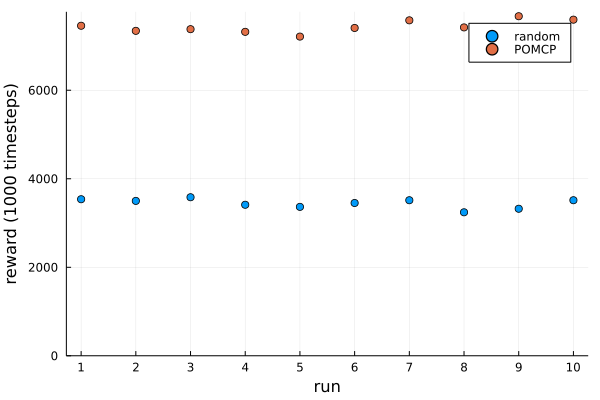

In [115]:
plot(1:iters, [random_R,POMCP_R], 
    seriestype = :scatter, 
    label=["random" "POMCP"], 
    ylims = (0,maximum(POMCP_R)+100),
    xticks = 0:1:iters,
    xlabel = "run",
    ylabel = "reward (" * string(steps) * " timesteps)"
)